Imports

In [1]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
import os
import sklearn.preprocessing
# type artefacts
from typing import Tuple, List, Union
from pandas import DataFrame

# min-max scaler
scaler = sklearn.preprocessing.MinMaxScaler()

Utility

In [2]:
# interested in x, y, z and anomaly label
FEATURES = ["x", "y", "z", "anomaly"]

def get_file_list_from_directory(directory_path: str) -> List[str]:
    """
    Returns a List of filename paths
        :param directory_path: string of a path to recursively search through
        :return: List(filename_paths)
    """
    datasets = []
    for subdir, dirs, files in os.walk(directory_path):
        for file in files:
            if file.find('.csv') != -1:
                datasets.append(os.path.join(subdir, file))
    return datasets


def get_frames_from_file_list(filelist: List[str], columns: Union[List[int], None],
                              seperator: str = ",") -> List[
    DataFrame]:
    """
    This method returns a List of DataFrames and eventually stores it as pickle file
        :param filelist: List(paths)
        :param columns: List(indices)
        :param name: filename to be, if None the dataframes will not be stored
        :param seperator: ; or ,
        :return:
    """
    dataframes = []
    scaler = sklearn.preprocessing.MinMaxScaler()
    for i in range(len(filelist)):
        if not columns:
            series = pd.read_csv(filelist[i], header=0, sep=seperator)
            # comment line below to get first column as a feature
            series = series.drop(series.columns[0], axis=1)
        else:
            # read from column list input
            series = pd.read_csv(filelist[i], usecols=columns, header=0, sep=seperator)
        dataframes.append(series)
    # fit features for all dataframes
    dataframes = fit_min_max_frames(dataframes)
    return dataframes

def fit_min_max_frames(frames: List[DataFrame]) -> List[DataFrame]:
    """
    Performs a Min/Max Scaling on a List of DataFrames (between 0, 1)
        :param frames: List(pandas.DataFrame)
        :return: List(pandas.DataFrame)
    """
    for i, frame in enumerate(frames):
        for column in frame:
            if frame[column].dtype == np.float64 or frame[column].dtype == np.int64:
                scaler.fit(np.array(frame[column]).reshape(-1, 1))
                frame[column] = scaler.fit_transform(frame[[column]])
    return frames

def get_basic_info_from_frames(frames: List[DataFrame]) -> int:
    """
    Get the sum of all samples in the list of dataframes
        :param frames: List(pandas.DataFrame)
        :return: int
    """
    sum = 0
    anomalies = 0
    normal = 0
    for frames in frames:
        sum += len(frames)
        anomalies += frames.anomaly.value_counts()[1]
        normal += frames.anomaly.value_counts()[0]
    return sum, anomalies, normal

def join_frames_from_list(frames: List[DataFrame]) -> DataFrame:
    """
    Joins a list of dataframes by appending them
        :param frames: List(pandas.DataFrame)
        :return: pandas.DataFrame
    """
    result = pd.concat(frames)
    assert result is not None
    return result

def train_model(model, model_name):
    """
    Model Training cycle requires sklearn Model as input
        :param model: sklearn.Model
        :param model_name: str
        :return: str
    """
    print(model_name)
    accuracy = {}

    # Fitting model
    model = model.fit(X_train, y_train)
    pred = model.predict(X_test)

    #Model accuracy
    acc = accuracy_score(y_test, pred)*100
    accuracy[model_name] = acc
    print('accuracy_score',acc)
    print()

    # Classification Report
    print('Classification Report')
    print(classification_report(y_test, pred))
    return "Done"

Loading

In [3]:
# load the file paths
train_paths = get_file_list_from_directory('./data/train')
test_paths = get_file_list_from_directory('./data/test')
# load the data in pandas
train_frames = get_frames_from_file_list(train_paths, columns=FEATURES)
test_frames = get_frames_from_file_list(test_paths, columns=FEATURES)
# assert loading is done
assert len(train_frames) == 20
assert len(test_frames) == 5

Exploration

In [4]:
# basic info
train_count, train_anomaly_count, train_normal_count = get_basic_info_from_frames(train_frames)
test_count, test_anomaly_count, test_normal_count = get_basic_info_from_frames(test_frames)
# distribution info
train_normal_dist = round((train_count - train_anomaly_count) / train_count, 3)
test_normal_dist = round((test_count - test_anomaly_count) / test_count, 3)
train_anomaly_dist = round(train_anomaly_count / train_count, 3)
test_anomaly_dist = round(test_anomaly_count / test_count, 3)
# output info
print(f"\n training samples => \n\t overall: {train_count}, \n\t normal: {train_normal_count}, \n\t anomalous: {train_anomaly_count}")
print(f"\n training distribution => \n\t normal: {train_normal_dist}, \n\t anomalous: {train_anomaly_dist}")
print(f"\n testing samples => \n\t overall: {test_count}, \n\t normal: {test_normal_count}, \n\t anomalous: {test_anomaly_count}")
print(f"\n testing distribution => \n\t normal: {test_normal_dist}, \n\t anomalous: {test_anomaly_dist}")


 training samples => 
	 overall: 134229, 
	 normal: 127656, 
	 anomalous: 6573

 training distribution => 
	 normal: 0.951, 
	 anomalous: 0.049

 testing samples => 
	 overall: 30030, 
	 normal: 28420, 
	 anomalous: 1610

 testing distribution => 
	 normal: 0.946, 
	 anomalous: 0.054


choose example frames and explore

In [5]:
# get the first frame
train_example = train_frames[0]
test_example = test_frames[0]
# output info
print("TRAINING\n")
print(train_example.info())
print(train_example.describe())
print("TESTING\n")
print(test_example.info())
print(test_example.describe())

TRAINING

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6192 entries, 0 to 6191
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   x        6192 non-null   float64
 1   y        6192 non-null   float64
 2   z        6192 non-null   float64
 3   anomaly  6192 non-null   float64
dtypes: float64(4)
memory usage: 193.6 KB
None
                 x            y            z      anomaly
count  6192.000000  6192.000000  6192.000000  6192.000000
mean      0.414026     0.382870     0.561681     0.037791
std       0.225976     0.279298     0.200885     0.190705
min       0.000000     0.000000     0.000000     0.000000
25%       0.222008     0.165087     0.425730     0.000000
50%       0.362818     0.254432     0.527771     0.000000
75%       0.626405     0.567168     0.726256     0.000000
max       1.000000     1.000000     1.000000     1.000000
TESTING

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5929 entries, 0 to 5928
Data

Visualizing

In [6]:
# configure seaborn
sns.set(rc={'figure.figsize':(12, 6)})
sns.set_theme()
sns.set_style("dark")

Text(0.5, 1.0, 'Training Example Frame')

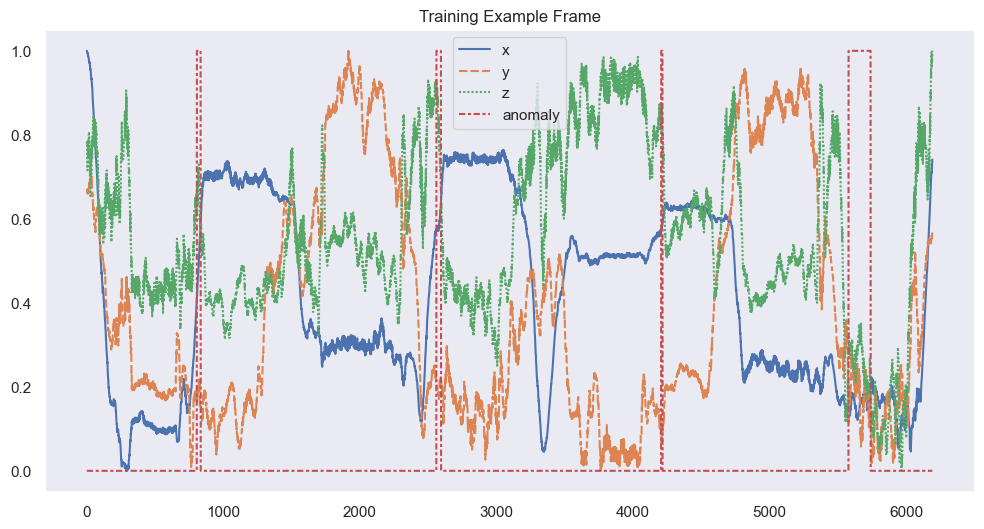

In [7]:
sns.lineplot(data=train_example).set_title('Training Example Frame')

Text(0.5, 1.0, 'Testing Example Frame')

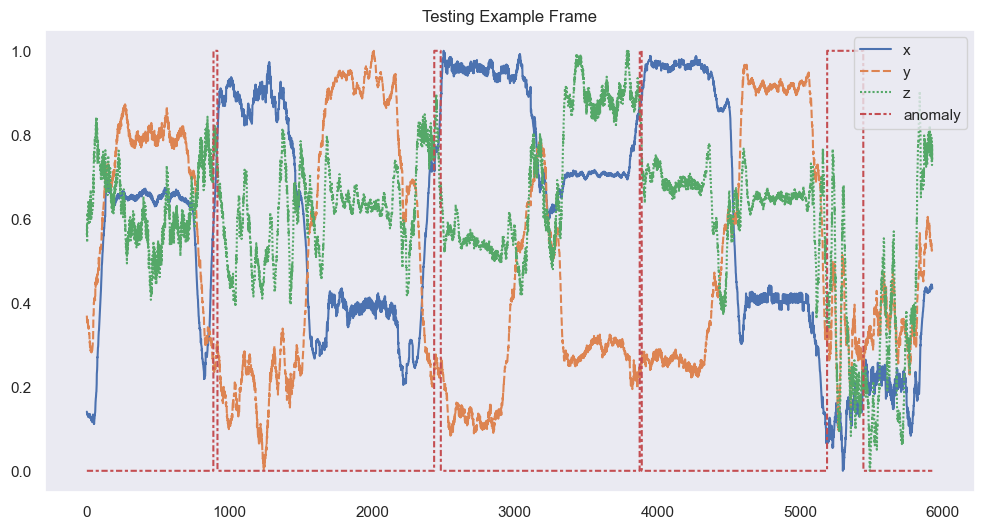

In [8]:
sns.lineplot(data=test_example).set_title('Testing Example Frame')

Joining

In [9]:
train = join_frames_from_list(train_frames)
test = join_frames_from_list(test_frames)
print("Training shape: ", train.shape)
print("Testing shape: ", test.shape)

Training shape:  (134229, 4)
Testing shape:  (30030, 4)


Visualize some random sample

In [11]:
chart = alt.Chart(train.sample(n=1000)).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='anomaly:N'
).properties(
    width=150,
    height=150
).repeat(
    row=['x', 'y', 'z'],
    column=['z', 'y', 'x']
).interactive()
chart

alt.RepeatChart(...)

Learning

In [13]:
#Importing Machine Learning Model
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

#statistical Tools
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [14]:
X_train = train.drop(columns=["anomaly"], axis=1)
y_train = train["anomaly"]
X_test = test.drop(columns=["anomaly"], axis=1)
y_test = test["anomaly"]

In [15]:
cat = CatBoostClassifier(verbose = 0, n_estimators = 1000)

train_model(cat, "Cat Boost")

Cat Boost
accuracy_score 92.74059274059275

Classification Report
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96     28420
         1.0       0.27      0.21      0.24      1610

    accuracy                           0.93     30030
   macro avg       0.61      0.59      0.60     30030
weighted avg       0.92      0.93      0.92     30030



'Done'

In [16]:
import joblib
rfc = RandomForestClassifier(n_estimators = 1500, n_jobs=-1, max_depth=15,
                             min_samples_split=5, min_samples_leaf=3)

train_model(rfc, 'Random Forest Classifier')



Random Forest Classifier
accuracy_score 93.3000333000333

Classification Report
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     28420
         1.0       0.29      0.18      0.22      1610

    accuracy                           0.93     30030
   macro avg       0.62      0.58      0.59     30030
weighted avg       0.92      0.93      0.93     30030



'Done'

In [31]:
# save
joblib.dump(rfc, "./saved_models/my_random_forest.joblib")

# load
# loaded_rfc = joblib.load("my_random_forest.joblib")

['./saved_models/my_random_forest.joblib']